<a href="https://colab.research.google.com/github/powerflow77/DeepLearning/blob/main/MLP-SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 방식만 기록
- 학습은 잘 안 됐음

In [10]:
! pip install shap

In [28]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import LambdaCallback

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [48]:
np.random.seed(511)

num_data = 30_000
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e
y = y.reshape(-1, 1)

#X = X.astype(np.float32)
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)
#y = y.astype(np.float32)

x_train = X[:int(num_data*0.8)]
y_train = y[:int(num_data*0.8)]

x_test = X[int(num_data*0.8):]
y_test = y[int(num_data*0.8):]


print(x_train.shape)
print(y_train.shape)
print()
print(x_test.shape)
print(y_test.shape)


(24000, 2)
(24000, 1)

(6000, 2)
(6000, 1)


In [58]:
'''
x_train = [1, 2, 3]
y_train = [1, 2, 3]

#W = tf.Variable(tf.random.normal([2]), name="weight")
#b = tf.Variable(tf.random.normal([1]), name="bias")

#hypothesis=x_train*W+b
# 모델 정의
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, input_dim=2, activation='relu'))  # input_dim을 2로 변경
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation=None))


# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# 모델 학습
model.fit(x_train, y_train, epochs=800)
'''

'\nx_train = [1, 2, 3]\ny_train = [1, 2, 3]\n \n#W = tf.Variable(tf.random.normal([2]), name="weight")\n#b = tf.Variable(tf.random.normal([1]), name="bias")\n \n#hypothesis=x_train*W+b\n# 모델 정의\nmodel = tf.keras.models.Sequential()\nmodel.add(tf.keras.layers.Dense(128, input_dim=2, activation=\'relu\'))  # input_dim을 2로 변경\nmodel.add(tf.keras.layers.Dense(64, activation=\'relu\'))\nmodel.add(tf.keras.layers.Dense(32, activation=\'relu\'))\nmodel.add(tf.keras.layers.Dense(1, activation=None))\n\n\n# 모델 컴파일\nmodel.compile(loss=\'mean_squared_error\', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))\n\n# 모델 학습\nmodel.fit(x_train, y_train, epochs=800)\n'

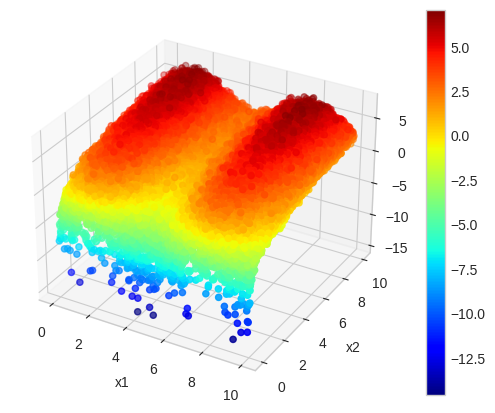

In [13]:
fig1 = plt.figure(figsize=(8,5))
ax1 = fig1.add_subplot(111, projection='3d')
t = ax1.scatter(x1, x2, y, c=y, cmap='jet', marker='o')

fig1.colorbar(t) # 컬러바

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')

plt.show()


In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size=64)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=len(y_train)).batch(batch_size=64)

In [47]:
class ANN(Model):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = layers.Dense(units=64, input_dim=x_train.shape[1], activation=tf.nn.relu)
        self.dropout1 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(units=64, activation=tf.nn.relu)
        self.dropout2 = layers.Dropout(0.5)
        self.out = layers.Dense(units=y_train.shape[1], activation=None)

    def call(self, x, is_training=False):
        x = self.fc1(x)
        if is_training:
            x = self.dropout1(x)
        x = self.fc2(x)
        if is_training:
            x = self.dropout2(x)
        x = self.out(x)
        return x

In [16]:
loss_fn = tf.keras.losses.MeanSquaredError()

optimizer = tf.optimizers.Adam(learning_rate=0.001)

model = ANN()

In [17]:
losslist= []

with tf.device('/GPU:0'):
    for epoch in range(1, 800+1):
        total_loss = 0.0
        num_batches = 0

        for x, y_true in train_dataset:
            with tf.GradientTape() as tape: # pred와 loss 추적
                y_pred = model(x, is_training=True)
                loss = loss_fn(y_true, y_pred)
                total_loss += loss

            gradients = tape.gradient(loss, model.trainable_variables) # gradient 계산
            optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # weight 업데이트
            num_batches += 1

        losslist.append(total_loss / num_batches)

        if epoch % 100 == 0:
            print(f"[Epoch]: {epoch}/800,  [Loss]: {np.round(total_loss / num_batches, 3)}")

[Epoch]: 100/800,  [Loss]: 0.25600001215934753
[Epoch]: 200/800,  [Loss]: 0.2540000081062317
[Epoch]: 300/800,  [Loss]: 0.25200000405311584
[Epoch]: 400/800,  [Loss]: 0.2529999911785126
[Epoch]: 500/800,  [Loss]: 0.25
[Epoch]: 600/800,  [Loss]: 0.25099998712539673
[Epoch]: 700/800,  [Loss]: 0.24799999594688416
[Epoch]: 800/800,  [Loss]: 0.25


In [18]:
total_loss = 0.0
num_batches = 0
predlist= []

for x, y_true in test_dataset:
    y_pred = model(x, is_training=False)  # 평가 모드에서는 is_training=False
    loss = loss_fn(y_true, y_pred)
    total_loss += loss
    num_batches += 1
    predlist += y_pred.numpy().ravel().tolist()

avg_loss = total_loss / num_batches
print(f'[Avg_Loss]: {avg_loss}')

[Avg_Loss]: 0.2630234360694885


In [24]:
x11 = x_test[:, 0].numpy().ravel()
x22 = x_test[:, 1].numpy().ravel()
y00 = np.array(predlist).ravel()

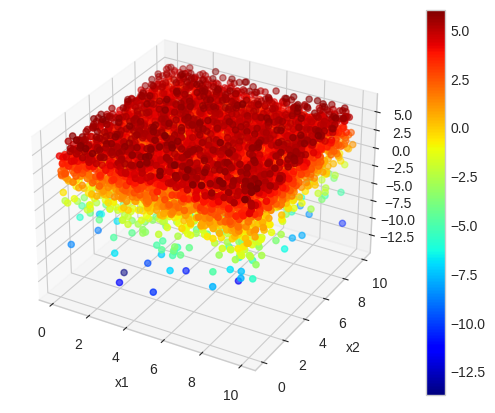

In [25]:
fig1 = plt.figure(figsize=(8,5))
ax1 = fig1.add_subplot(111, projection='3d')
t = ax1.scatter(x11, x22, y00, c=y00, cmap='jet', marker='o')

fig1.colorbar(t) # 컬러바

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')

plt.show()

In [62]:
explainer = shap.KernelExplainer(model.predict, x_train.numpy())
shap_values = explainer.shap_values(x_test.numpy()[0, :].reshape(-1, 2))

750/750 [==============================] - 1s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1500/1500 [==============================] - 2s 1ms/step


In [63]:
print(shap_values)

[array([[ 1.72580838, -4.9881398 ]])]


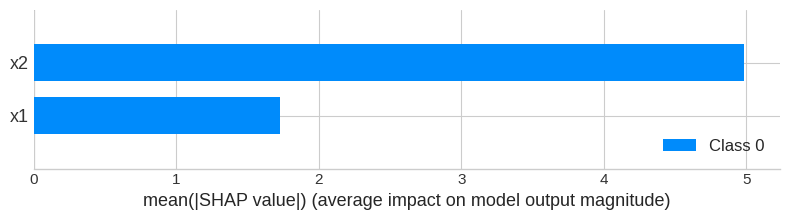

In [65]:
shap.summary_plot(shap_values, x_test.numpy()[0, :].reshape(-1, 2), feature_names=['x1', 'x2'])